In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from squaternion import Quaternion

In [68]:
class imuFilter:
    def __init__(self, R, Q):
        self.q = Quaternion()
        self.dt = 0.
        self.x = np.array([0]*9) # [qb,ab,wb]
        self.abias = 0
        self.wbias = 0
        self.qbias = Quaternion(0,0,0,0)
        self.R = R
        self.Q = Q
        self.P = Q
    
    def model(self, accel, gyro):
        """
        accel/gyro: (x,y,z) readings from IMU
        q: quaternion attitude estimate
        a: acceleration
        g: esitmate of gravity vector
        """
        abias = self.x[3:6]
        a = accel - self.abias
        wbias = self.x[6:]
        w = gyro - self.wbias
        q = self.q + 0.5*self.dt*self.q * Quaternion(0, w[0], w[1], w[2])
        g = np.array(q.to_rot())[2,:] # save a transpose g[2,:] = (g.T)[:,2]
        return q,a,g
        
    def correction(self):
        o = self.x[:4]
        ab = self.x[4:7]
        wb = self.x[7:]
        
        self.abias = self.abias*v-ab
        self.wbias = self.wbias-wb
        
    def kf(self,z,g):
        gx,gy,gz = g
        k = 0.001 # fixme
        self.x = np.array([0]*9)
        H = np.array([
            [  0,  gz, -gy,     0, -k*gz,  k*gy, 1, 0, 0],
            [-gz,   0,  gx,  k*gz,     0, -k*gx, 0, 1, 0],
            [ gy, -gx,   0, -k*gy,  k*gx,     0, 0, 0, 1]
        ])
        y = z
        s = self.R + H @ self.P @ H.T
        K = self.P @ H.T @ inv(s)        # kalman gain
        self.x = K @ y                   # a posteriori state
        self.P = self.P - K @ H @ self.P # a posteriori covariance
        
    def pose(self, accel, gyro):
        q,a,g = self.model(accel, gyro)
        z = a-g
        self.kf(z,g)
        self.correction()
        return (self.q, a, g)

In [69]:
filt = imuFilter(
    R=0.1*np.eye(3),
    Q=0.1*np.eye(3)
)

In [70]:
class GausianSensor:
    def __init__(self, mu, std, size):
        self.mu = mu
        self.std = std
        self.size = size
        
    def generate(self, path=None):
        mu = self.mu
        std = self.std
        size = self.size
        if path is None:
            self.data = np.random.normal(mu,std,(size,3))
        else:
            self.data = path + np.random.normal(mu,std,(size,3))

class IMU:
    def __init__(self, accel, gyro):
        self.accelerometer = GausianSensor(*accel)
        self.gyroscope = GausianSensor(*gyro)
        
    def generate(self, apath=None, gpath=None):
        self.accelerometer.generate(apath)
        self.gyroscope.generate(gpath)

        
a = (0.0, 0.001, 600)
g = (0.0, 0.001, 600)
imu = IMU(a,g)

acc = np.array([[0,0,1] for _ in range(600)])
gy = np.array([[0,0,0] for _ in range(600)])
imu.generate(acc,gy)

# imu.data

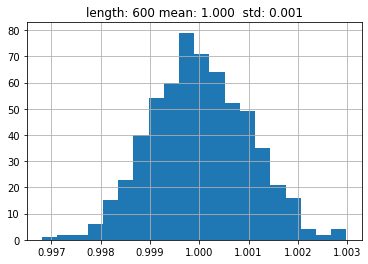

In [71]:
n = 2
sensor = imu.accelerometer
plt.hist(sensor.data[:,n], bins=20)
plt.title(f"length: {sensor.data.shape[0]} mean: {np.mean(sensor.data[:,n]):0.3f}  std: {np.std(sensor.data[:,n]):0.3f}")
plt.grid();

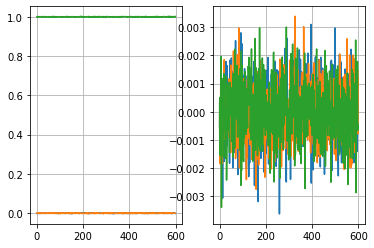

In [72]:
plt.subplot(1,2,1)
plt.plot(imu.accelerometer.data)
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(imu.gyroscope.data)
plt.grid(True);

In [73]:
for a, g in zip(imu.accelerometer.data, imu.gyroscope.data):
    filt.pose(a,g)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 9)